# Part1: Ten states representation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers, optimizers

def tau(s,a):
    if (s[0] and s[9]) == 0 : s=np.roll(s,a)
    return s

def rho(s):
    return ((s[0]==1)+2*(s[9]==1))    

def terminal_state(s):
    return (s[0]==1 or s[9]==1)    

gamma=0.8
invT = 1

In [2]:
# the network
inputs = layers.Input(shape=(10,))
h = layers.Dense(20, activation='relu')(inputs)
outputs = layers.Dense(2, activation='linear')(h)

model = models.Model(inputs=inputs, outputs=outputs)
RMSprop = optimizers.RMSprop(lr=0.01)
model.compile(loss='mse', optimizer=RMSprop)

In [3]:
for trial in range(400):
    s = np.array([0,0,0,0,0,0,0,1,0,0])
    for t in range(0,10):
        if terminal_state(s): break
        if trial > 30 and invT > 0.1: invT -= 0.001
        prediction=model.predict(s.reshape(1,10), steps=1, verbose=0)
        aidx=np.argmax(prediction)
        if np.random.rand() < invT : aidx=1-aidx
        a=2*aidx-1
        next_s = tau(s,a)
        if terminal_state(next_s): 
            y = rho(next_s)
        else:
            y = gamma*np.max(model.predict(next_s.reshape(1,10), steps=1, verbose=0))
        prediction[0,aidx]=y
        model.fit(s.reshape(1,10), prediction, epochs=1, verbose=0)
        s = np.copy(next_s)


Q-Values and Policy generated

In [4]:
policy = np.zeros(10)
Q=[]
s = np.array([1,0,0,0,0,0,0,0,0,0])

for i in range(0,10):
    Qs=model.predict(s.reshape(1,10), steps=1)
    Q.append(Qs)
    aidx=np.argmax(Qs)
    policy[i]=2*aidx-1
    s = np.roll(s,1)
print(np.transpose(Q))
print('policy:',np.transpose(policy))

[[[0.96803534 0.8101573  0.8315115  0.79259086 0.5991806  0.61579823
   0.76312673 1.0989364  1.2157247  1.2229034 ]]

 [[0.98403335 1.4067031  0.6679058  0.7322889  0.77526397 0.99894094
   1.2187111  1.6052873  2.0314152  1.2814515 ]]]
policy: [ 1.  1. -1. -1.  1.  1.  1.  1.  1.  1.]




# Part2: Integer Input


In [9]:

def tau(s,a):
    if (s != 0 and s != 9) : s = s+a
    return s

def rho(s):
    return ((s == 0)+2*(s == 9))    

def terminal_state(s):
    return (s==0 or s==9)    

gamma=0.8
invT = 1

In [10]:
# the network
inputs = layers.Input(shape=(1,))
h = layers.Dense(10, activation='relu')(inputs)
outputs = layers.Dense(2, activation='linear')(h)

model = models.Model(inputs=inputs, outputs=outputs)
RMSprop = optimizers.RMSprop(lr=0.01)
model.compile(loss='mse', optimizer=RMSprop)

In [11]:
for trial in range(400):
    input = 6
    s= np.array([input])
    for t in range(0,10):
        if terminal_state(s): break
        if trial > 30 and invT > 0.1: invT -= 0.001
        prediction=model.predict(s.reshape(1,1), steps=1, verbose=0)
        aidx=np.argmax(prediction)
        if np.random.rand() < invT : aidx=1-aidx
        a=2*aidx-1
        next_s = tau(s,a)
        if terminal_state(next_s): 
            y = rho(next_s)
        else:
            y = gamma*np.max(model.predict(next_s.reshape(1,1), steps=1, verbose=0))
        prediction[0,aidx]=y
        model.fit(s.reshape(1,1), prediction, epochs=1, verbose=0)
        s = np.copy(next_s)


Q-Values and Policy generated

In [12]:
policy = np.zeros(10)
Q=[]
s = np.array([0])
for i in range(0,10):
    Qs=model.predict(s.reshape(1,1), steps=1)
    Q.append(Qs)
    aidx=np.argmax(Qs)
    policy[i]=2*aidx-1
    s = s+1
print(np.transpose(Q))
print('policy:',np.transpose(policy))

[[[ 0.00982988  0.11931337  0.35386476  0.48853293  0.62320113
    0.75786924  0.8925376   1.0272058   1.1618739   1.296542  ]]

 [[-0.36439455 -0.27556625 -0.01060781  0.35007346  0.7107549
    1.071436    1.4321175   1.7927989   2.15348     2.514161  ]]]
policy: [-1. -1. -1. -1.  1.  1.  1.  1.  1.  1.]


# Part3: MNIST model input


(60000, 28, 28)


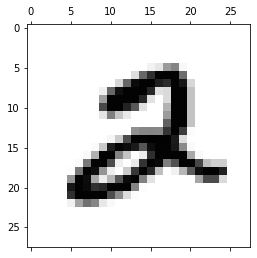

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers, optimizers, datasets, utils, losses

(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
print(np.shape(x_train))
plt.matshow(255-x_train[5,:,:], cmap='gray')

In [26]:
x_train = x_train.reshape(60000, 28, 28, 1)/255
x_train = x_train[:10024,:,:,:]
x_test = x_test.reshape(10000, 28, 28, 1)/255
y_train = utils.to_categorical(y_train[:10024], 10)
y_test = utils.to_categorical(y_test, 10)

inputs = layers.Input(shape=(28, 28, 1,))
x=layers.Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
x=layers.Conv2D(64, (3, 3), activation='relu')(x)
x=layers.MaxPooling2D(pool_size=(2, 2))(x)
x=layers.Dropout(0.25)(x)
x=layers.Flatten()(x)
x=layers.Dense(128, activation='relu')(x)
x=layers.Dropout(0.5)(x)
outputs=layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))


Epoch 1/10
79/79 [==============================] - 22s 280ms/step - loss: 2.3055 - accuracy: 0.1110 - val_loss: 2.2960 - val_accuracy: 0.1391
Epoch 2/10
79/79 [==============================] - 22s 277ms/step - loss: 2.2962 - accuracy: 0.1227 - val_loss: 2.2846 - val_accuracy: 0.1634
Epoch 3/10
79/79 [==============================] - 22s 280ms/step - loss: 2.2844 - accuracy: 0.1398 - val_loss: 2.2733 - val_accuracy: 0.2023
Epoch 4/10
79/79 [==============================] - 22s 279ms/step - loss: 2.2740 - accuracy: 0.1545 - val_loss: 2.2620 - val_accuracy: 0.2522
Epoch 5/10
79/79 [==============================] - 22s 277ms/step - loss: 2.2622 - accuracy: 0.1749 - val_loss: 2.2504 - val_accuracy: 0.3023
Epoch 6/10
79/79 [==============================] - 22s 280ms/step - loss: 2.2508 - accuracy: 0.1866 - val_loss: 2.2385 - val_accuracy: 0.3369
Epoch 7/10
79/79 [==============================] - 22s 277ms/step - loss: 2.2408 - accuracy: 0.2053 - val_loss: 2.2262 - val_accuracy: 0.3639

In [27]:
y_pred = model.predict(x_test)

In [28]:
y_pred[1]

array([0.10251051, 0.08863058, 0.10310771, 0.10161319, 0.10712947,
       0.09470204, 0.10160833, 0.09527826, 0.11005335, 0.09536657],
      dtype=float32)

In [29]:
def tau(s,a):
    if (s[0] and s[9]) == 0 : s=np.roll(s,a)
    return s

def rho(s):
    return ((s[0]==1)+2*(s[9]==1))    

def terminal_state(s):
    return (s[0]==1 or s[9]==1)    

gamma=0.8
invT = 1

In [30]:
# the network
inputs = layers.Input(shape=(10,))
h = layers.Dense(20, activation='relu')(inputs)
outputs = layers.Dense(2, activation='linear')(h)

model = models.Model(inputs=inputs, outputs=outputs)
RMSprop = optimizers.RMSprop(lr=0.01)
model.compile(loss='mse', optimizer=RMSprop)

In [31]:
for trial in range(400):
    s = y_pred[1]
    for t in range(0,10):
        if terminal_state(s): break
        if trial > 30 and invT > 0.1: invT -= 0.001
        prediction=model.predict(s.reshape(1,10), steps=1, verbose=0)
        aidx=np.argmax(prediction)
        if np.random.rand() < invT : aidx=1-aidx
        a=2*aidx-1
        next_s = tau(s,a)
        if terminal_state(next_s): 
            y = rho(next_s)
        else:
            y = gamma*np.max(model.predict(next_s.reshape(1,10), steps=1, verbose=0))
        prediction[0,aidx]=y
        model.fit(s.reshape(1,10), prediction, epochs=1, verbose=0)
        s = np.copy(next_s)

Q-Values and Policy generated


In [24]:
policy = np.zeros(10)
Q=[]
s = np.array([1,0,0,0,0,0,0,0,0,0])

for i in range(0,10):
    Qs=model.predict(s.reshape(1,10), steps=1)
    Q.append(Qs)
    aidx=np.argmax(Qs)
    policy[i]=2*aidx-1
    s = np.roll(s,1)
print(np.transpose(Q))
print('policy:',np.transpose(policy))

[[[ 0.23865758  0.2509752   0.11164142  0.10483261 -0.15577662
    0.04641047 -0.03825612 -0.04737083  0.015613    0.35242653]]

 [[-0.13309106  0.09589105 -0.0231336  -0.06245815 -0.211565
   -0.23046705 -0.019216    0.05351142 -0.03796541 -0.10223649]]]
policy: [-1. -1. -1. -1. -1. -1.  1.  1. -1. -1.]
